Das Ausführen der ersten 10 Abschnitte kann einige Zeit dauern. Wenn man den ersten auswählt und 10 x auf Play klickt, laufen die nacheinander ab (* solange aktiv). Wenn man einen Abschnitt ändert, dann muss man ab diesem Abschnitt alle folgenden erneut ausführen, um mit den Daten oder der Kamera zu experimentieren.

First, let's load the JSON file which describes the human pose task.  This is in COCO format, it is the category descriptor pulled from the annotations file.  We modify the COCO category slightly, to add a neck keypoint.  We will use this task description JSON to create a topology tensor, which is an intermediate data structure that describes the part linkages, as well as which channels in the part affinity field each linkage corresponds to.

In [1]:
import json
import trt_pose.coco

with open('human_pose.json', 'r') as f:
    human_pose = json.load(f)

topology = trt_pose.coco.coco_category_to_topology(human_pose)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-c0qijr7j because the default path (/home/dumbledore/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Next, we'll load our model.  Each model takes at least two parameters, *cmap_channels* and *paf_channels* corresponding to the number of heatmap channels
and part affinity field channels.  The number of part affinity field channels is 2x the number of links, because each link has a channel corresponding to the
x and y direction of the vector field for each link.

In [2]:
import trt_pose.models

num_parts = len(human_pose['keypoints'])
num_links = len(human_pose['skeleton'])

print(num_parts,num_links)

model = trt_pose.models.resnet18_baseline_att(num_parts, 2 * num_links).cuda().eval()

18 21


Next, let's load the model weights.  You will need to download these according to the table in the README.

In [3]:
import torch

MODEL_WEIGHTS = 'resnet18_baseline_att_224x224_A_epoch_249.pth'

model.load_state_dict(torch.load(MODEL_WEIGHTS))

<All keys matched successfully>

In order to optimize with TensorRT using the python library *torch2trt* we'll also need to create some example data.  The dimensions
of this data should match the dimensions that the network was trained with.  Since we're using the resnet18 variant that was trained on
an input resolution of 224x224, we set the width and height to these dimensions.

In [4]:
WIDTH = 224
HEIGHT = 224

data = torch.zeros((1, 3, HEIGHT, WIDTH)).cuda()

Next, we'll use [torch2trt](https://github.com/NVIDIA-AI-IOT/torch2trt) to optimize the model.  We'll enable fp16_mode to allow optimizations to use reduced half precision.

In [5]:
import torch2trt

model_trt = torch2trt.torch2trt(model, [data], fp16_mode=True, max_workspace_size=1<<25)

The optimized model may be saved so that we do not need to perform optimization again, we can just load the model.  Please note that TensorRT has device specific optimizations, so you can only use an optimized model on similar platforms.

In [6]:
OPTIMIZED_MODEL = 'resnet18_baseline_att_224x224_A_epoch_249_trt.pth'

torch.save(model_trt.state_dict(), OPTIMIZED_MODEL)

We could then load the saved model using *torch2trt* as follows.

In [7]:
from torch2trt import TRTModule

model_trt = TRTModule()
model_trt.load_state_dict(torch.load(OPTIMIZED_MODEL))

<All keys matched successfully>

We can benchmark the model in FPS with the following code

In [8]:
import time

t0 = time.time()
torch.cuda.current_stream().synchronize()
for i in range(50):
    y = model_trt(data)
torch.cuda.current_stream().synchronize()
t1 = time.time()

print(50.0 / (t1 - t0))

11.865600609068


Next, let's define a function that will preprocess the image, which is originally in BGR8 / HWC format.

In [9]:
import cv2
import torchvision.transforms as transforms
import PIL.Image

mean = torch.Tensor([0.485, 0.456, 0.406]).cuda()
std = torch.Tensor([0.229, 0.224, 0.225]).cuda()
device = torch.device('cuda')

def preprocess(image):
    global device
    device = torch.device('cuda')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = PIL.Image.fromarray(image)
    image = transforms.functional.to_tensor(image).to(device)
    image.sub_(mean[:, None, None]).div_(std[:, None, None])
    return image[None, ...]

Next, we'll define two callable classes that will be used to parse the objects from the neural network, as well as draw the parsed objects on an image.

In [10]:
from trt_pose.draw_objects import DrawObjects
from trt_pose.parse_objects import ParseObjects

parse_objects = ParseObjects(topology)
draw_objects = DrawObjects(topology)

Assuming you're using NVIDIA Jetson, you can use the [jetcam](https://github.com/NVIDIA-AI-IOT/jetcam) package to create an easy to use camera that will produce images in BGR8/HWC format.

If you're not on Jetson, you may need to adapt the code below.

# Testbild laden und Größe entsprechend Modell anpassen

(1100, 629) (391, 223)
(391, 223)


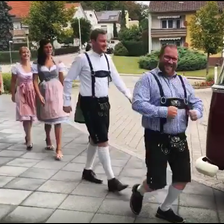

In [18]:
import numpy as np
from PIL import Image
image = Image.open(open("seewasen1.png", 'rb'))
h=224
ratio = h / image.size[1]
newsize = (int(ratio * image.size[0]), int(ratio * image.size[1]) )
print(image.size, newsize)
image=image.resize([newsize[0],newsize[1]],Image.ANTIALIAS)


#image1 = image.crop((image.size[0] - h, 0, image.size[0], h))
image1  = image.crop((60, 0, h+60, h))
print(image.size)
image1

# Ergebnis wird  später in diesem Widget angezeigt

In [12]:
import ipywidgets
from IPython.display import display

image_w = ipywidgets.Image(format='jpeg')

display(image_w)

Image(value=b'', format='jpeg')

Finally, we'll define the main execution loop.  This will perform the following steps

1.  Preprocess the camera image
2.  Execute the neural network
3.  Parse the objects from the neural network output
4.  Draw the objects onto the camera image
5.  Convert the image to JPEG format and stream to the display widget

In [16]:
import numpy
from jetcam.utils import bgr8_to_jpeg

def process_image(image1):
    image = numpy.array(image1)
    data = preprocess(image)
    cmap, paf = model_trt(data)
    cmap, paf = cmap.detach().cpu(), paf.detach().cpu()
    counts, objects, peaks = parse_objects(cmap, paf)#, cmap_threshold=0.15, link_threshold=0.15)
    draw_objects(image, counts, objects, peaks)
    image_w.value = bgr8_to_jpeg(image[:, ::-1, :])
    

In [19]:
process_image(image1)   

hochscrollen zu Widget, um Ergebnis zu sehen

# Mehr test data

In [ ]:
from os import listdir
from os.path import isfile, join
import glob
mypath="./data/"
#onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
#onlyfiles
wasen=sorted(glob.glob(mypath + '*'))

# Stereokamera (folgende 2  Abschnitte, Ergebnis erscheint in Widget oben)
sensor-id=0 : Kamera 1,
sensor-id=1 : Kamera 2

In [14]:
# MIT License
# Copyright (c) 2019 JetsonHacks
# See license
# Using a CSI camera (such as the Raspberry Pi Version 2) connected to a
# NVIDIA Jetson Nano Developer Kit using OpenCV
# Drivers for the camera and OpenCV are included in the base image

import cv2

# gstreamer_pipeline returns a GStreamer pipeline for capturing from the CSI camera
# Defaults to 1280x720 @ 60fps
# Flip the image by setting the flip_method (most common values: 0 and 2)
# display_width and display_height determine the size of the window on the screen


def gstreamer_pipeline1(
    capture_width=1280,
    capture_height=720,
    display_width=320,
    display_height=240,
    framerate=30,
    flip_method=1,
):
    return (
        "nvarguscamerasrc sensor-id=0 ! "
        "video/x-raw(memory:NVMM), "
        "width=(int)%d, height=(int)%d, "
        "format=(string)NV12, framerate=(fraction)%d/1 ! "
        "nvvidconv flip-method=%d ! "
        "video/x-raw, width=(int)%d, height=(int)%d, format=(string)BGRx ! "
        "videoconvert ! "
        "video/x-raw, format=(string)BGR ! appsink"
        % (
            capture_width,
            capture_height,
            framerate,
            flip_method,
            display_width,
            display_height,
        )
    )

def gstreamer_pipeline(
    capture_width=1280,
    capture_height=720,
    display_width=1280,
    display_height=720,
    framerate=60,
    flip_method=0,
): "nvarguscamerasrc  sensor-id=1 !  appsink"



In [15]:
# wenn Bild schwarz, dann wurde cap evtl nicht geschlossen
# läuft, unendlich, stop klicken zum Restart

import time
from IPython.display import display, clear_output
from PIL import ImageChops
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
#from IPython.display import display, clear_output
import time



print(gstreamer_pipeline1(flip_method=0))
cap = cv2.VideoCapture(gstreamer_pipeline1(flip_method=0), cv2.CAP_GSTREAMER)

# clear and display is expensive.
if cap.isOpened():
    try:
        while True:
            ret_val, screenshot = cap.read()
            #print(type(screenshot))
            #clear_output(wait=True)
            image1 = Image.fromarray(screenshot)
            
            #print(image1.size)
            h=224
            ratio = h / image1.size[1]
            newsize = (int(ratio * image1.size[0]), int(ratio * image1.size[1]) )
            #print(image1.size, newsize)
            image1=image1.resize([newsize[0],newsize[1]],Image.ANTIALIAS)
    
            image1  = image1.crop((0, 0, h, h))
            process_image(image1) 
            
            ts = time.time()
            #print (ts)
    except:
        cap.release()
        cv2.destroyAllWindows()

nvarguscamerasrc sensor-id=0 ! video/x-raw(memory:NVMM), width=(int)1280, height=(int)720, format=(string)NV12, framerate=(fraction)30/1 ! nvvidconv flip-method=0 ! video/x-raw, width=(int)320, height=(int)240, format=(string)BGRx ! videoconvert ! video/x-raw, format=(string)BGR ! appsink


den folgenden Abschnitt sollte man nicht brauchen

In [ ]:
cap.release()
cv2.destroyAllWindows()    